In [2]:
import cv2
import numpy as np
import time
import menpo.io as mio
import matplotlib.pyplot as plt
import json
import os
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index
def load_img_lms(path,landmark_source):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(img_gray)
    if landmark_source == "menpo":
        img_menpo = mio.import_image(path)
        grp_name = img_menpo.landmarks.group_labels[0]
        landmarks = img_menpo.landmarks[grp_name].points.copy()
        # menpo 里面x,y反过来的
        landmarks_points = [(y,x) for x,y in landmarks]
    elif landmark_source == "sense":
        with open("wyw_manga_labeltrain.json",'r') as load_f:
            load_dict = json.load(load_f)
            #print(load_dict["labels"][0])第一张图
            landmarks_points = []
            for idx in range(68):
                points = load_dict["labels"][1]['annotations']['landmarks'][idx]['data']
                landmarks_points.append(points)
            h,w,c = img.shape
            landmarks_points = [(int(x*w),int(y*h)) for (x,y) in landmarks_points]
    return img,landmarks_points

In [30]:
dataset = os.listdir("../dataset/cropped_only")
dataset[:20]

['Nekodama_025_l.png',
 'RisingGirl_016_l.png',
 'OL_Lunch_023_l.png',
 'MisutenaideDaisy_014_l.pts',
 'OhWareraRettouSeitokai_006_r.pts',
 'ParaisoRoad_008_l.pts',
 'OhWareraRettouSeitokai_021_l.pts',
 'MisutenaideDaisy_003_l.png',
 'Raphael_013_l.pts',
 'PrismHeart_017_l.pts',
 'OhWareraRettouSeitokai_006_l.png',
 'MeteoSanStrikeDesu_014_l.pts',
 'Ningyoushi_008_l.pts',
 'MomoyamaHaikagura_019_r.png',
 'RinToSiteSippuNoNaka_004_l.png',
 'RisingGirl_009_r.pts',
 'PrayerHaNemurenai_017_r.png',
 'RisingGirl_017_l.pts',
 'ParaisoRoad_006_l.pts',
 'Raphael_008_l.pts']

In [76]:
img,landmarks_points = load_img_lms("../dataset/cropped_only/Raphael_008_l.png","menpo")

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2,landmarks_points2 = load_img_lms("../dataset/cropped_only/Raphael_013_l.png","menpo")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

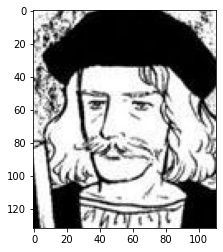

In [77]:
plt.imshow(img)

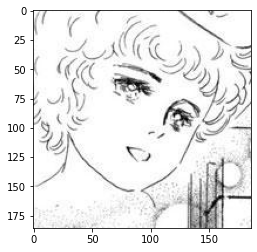

In [78]:
plt.imshow(img2)

In [79]:
points = np.array(landmarks_points, np.int32)
convexhull = cv2.convexHull(points)
# cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
cv2.fillConvexPoly(mask, convexhull, 255)

face_image_1 = cv2.bitwise_and(img, img, mask=mask)

# Delaunay triangulation
rect = cv2.boundingRect(convexhull)
subdiv = cv2.Subdiv2D(rect)
subdiv.insert(landmarks_points)
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)

indexes_triangles = []
for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])


    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = extract_index_nparray(index_pt1)

    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = extract_index_nparray(index_pt2)

    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = extract_index_nparray(index_pt3)

    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        triangle = [index_pt1, index_pt2, index_pt3]
        indexes_triangles.append(triangle)

In [80]:
points2 = np.array(landmarks_points2, np.int32)
convexhull2 = cv2.convexHull(points2)

lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    # wyw edited
    tr1_pt1 = np.array(tr1_pt1, np.int32)
    tr1_pt2 = np.array(tr1_pt2, np.int32)
    tr1_pt3 = np.array(tr1_pt3, np.int32)
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)
    
    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area



# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

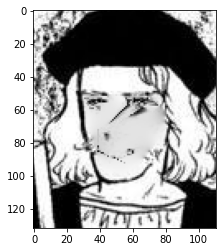

In [75]:
# manga to real photo
plt.imshow(seamlessclone[:,:,[2,1,0]])

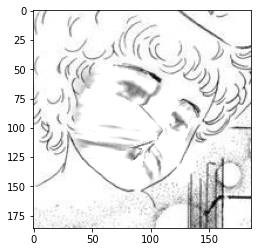

In [81]:
# real photo to manga
plt.imshow(seamlessclone[:,:,[2,1,0]])